# 44. e5-base ITQビット数検証

## 目的
- e5-base (768次元) で複数のITQビット数 (64, 96, 128 bits) を評価
- 候補数別のRecall@10を測定
- ビット数による精度・ハッシュサイズのトレードオフを分析

## 背景
- 実験43結果: e5-base + 96bits で Recall@10=99.9% (候補1000件)
- 推論速度: 579.1 texts/sec (GPU)
- 768次元では理論上 768bits まで可能だが、ビット数削減による効率化を検証

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from tqdm import tqdm
import time
import gc

from sentence_transformers import SentenceTransformer
from src.itq_lsh import ITQLSH

print('Setup complete')

Setup complete


In [3]:
# 定数設定
DB_PATH = '../data/experiment_400k.duckdb'
N_SAMPLES = 5000
N_BITS_LIST = [64, 96, 128]
CANDIDATE_SIZES = [100, 200, 500, 1000, 2000]
TOP_K = 10
N_QUERIES = 100
SEED = 42

MODEL_NAME = 'intfloat/multilingual-e5-base'
MODEL_DIM = 768

## 1. データ準備

In [4]:
# experiment_400kからサンプリング
conn = duckdb.connect(DB_PATH, read_only=True)

df_sample = conn.execute(f'''
    SELECT id, text, lang
    FROM documents
    ORDER BY hash(id + {SEED})
    LIMIT {N_SAMPLES}
''').fetchdf()

texts = df_sample['text'].tolist()

print(f'テストテキスト数: {len(texts)}')
print(f'言語分布:')
print(df_sample['lang'].value_counts())

conn.close()

# E5用にプレフィックス付与
texts_with_prefix = [f'passage: {t}' for t in texts]

テストテキスト数: 5000
言語分布:
lang
en    2504
ja    2496
Name: count, dtype: int64


In [5]:
# e5-base で埋め込み生成 (GPU)
print(f'e5-base ({MODEL_NAME}) をロード中...')
model = SentenceTransformer(MODEL_NAME, device='cuda')

t0 = time.time()
embeddings = model.encode(
    texts_with_prefix,
    normalize_embeddings=False,
    show_progress_bar=True,
    batch_size=32
).astype(np.float32)

inference_time = time.time() - t0

print(f'\n埋め込み生成完了:')
print(f'  Shape: {embeddings.shape}')
print(f'  推論時間: {inference_time:.2f}秒 ({len(texts)/inference_time:.1f} texts/sec)')

del model
gc.collect()

e5-base (intfloat/multilingual-e5-base) をロード中...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]


埋め込み生成完了:
  Shape: (5000, 768)
  推論時間: 8.81秒 (567.6 texts/sec)


76

## 2. ハミング距離関数とRecall評価関数

In [6]:
def hamming_distance_batch(query_hash, candidate_hashes):
    """クエリと候補間のハミング距離を計算"""
    xor_result = np.bitwise_xor(query_hash, candidate_hashes)
    distances = np.sum(np.unpackbits(xor_result, axis=1), axis=1)
    return distances


def evaluate_recall(embeddings, hashes, candidate_sizes, top_k=10, n_queries=100, seed=42):
    """Recall@K を評価"""
    rng = np.random.default_rng(seed)
    n_docs = len(embeddings)
    query_indices = rng.choice(n_docs, min(n_queries, n_docs), replace=False)
    
    results = {k: [] for k in candidate_sizes}
    
    for qi in tqdm(query_indices, desc='Evaluating'):
        query_emb = embeddings[qi]
        cosines = embeddings @ query_emb / (norm(embeddings, axis=1) * norm(query_emb) + 1e-10)
        gt_set = set(np.argsort(cosines)[-top_k:])
        
        query_hash = hashes[qi]
        distances = hamming_distance_batch(query_hash, hashes)
        sorted_indices = np.argsort(distances)
        
        for k in candidate_sizes:
            candidates = sorted_indices[:k]
            cand_cosines = embeddings[candidates] @ query_emb
            cand_cosines = cand_cosines / (norm(embeddings[candidates], axis=1) * norm(query_emb) + 1e-10)
            top_k_in_cands = candidates[np.argsort(cand_cosines)[-top_k:]]
            
            recall = len(gt_set & set(top_k_in_cands)) / top_k
            results[k].append(recall)
    
    return {k: np.mean(v) for k, v in results.items()}

## 3. 各ビット数でITQ学習と評価

In [7]:
itq_results = {}

for n_bits in N_BITS_LIST:
    print(f'\n{"="*60}')
    print(f'ITQ {n_bits} bits')
    print('='*60)
    
    # ITQ学習
    t0 = time.time()
    itq = ITQLSH(n_bits=n_bits, n_iterations=50, seed=SEED)
    itq.fit(embeddings)
    train_time = time.time() - t0
    
    # ハッシュ生成
    hashes = itq.transform(embeddings)
    
    # Recall評価
    recalls = evaluate_recall(embeddings, hashes, CANDIDATE_SIZES, TOP_K, N_QUERIES, SEED)
    
    itq_results[n_bits] = {
        'n_bits': n_bits,
        'train_time': train_time,
        'recalls': recalls,
        'hash_bytes_per_doc': n_bits // 8,
    }
    
    print(f'\n学習時間: {train_time:.2f}秒')
    print(f'Recall@{TOP_K}:')
    for k, r in recalls.items():
        print(f'  候補{k}件: {r*100:.1f}%')


ITQ 64 bits
ITQ学習開始: samples=5000, dim=768, bits=64
  Centering完了: mean_norm=0.8762
  PCA完了: explained_variance=56.56%
  ITQ iteration 10: quantization_error=0.9257
  ITQ iteration 20: quantization_error=0.9250
  ITQ iteration 30: quantization_error=0.9248
  ITQ iteration 40: quantization_error=0.9246
  ITQ iteration 50: quantization_error=0.9245
ITQ学習完了


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 105.97it/s]



学習時間: 0.19秒
Recall@10:
  候補100件: 83.9%
  候補200件: 92.4%
  候補500件: 97.6%
  候補1000件: 99.6%
  候補2000件: 100.0%

ITQ 96 bits
ITQ学習開始: samples=5000, dim=768, bits=96
  Centering完了: mean_norm=0.8762
  PCA完了: explained_variance=64.47%
  ITQ iteration 10: quantization_error=0.9353
  ITQ iteration 20: quantization_error=0.9348
  ITQ iteration 30: quantization_error=0.9346
  ITQ iteration 40: quantization_error=0.9345
  ITQ iteration 50: quantization_error=0.9344
ITQ学習完了


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 114.52it/s]



学習時間: 0.46秒
Recall@10:
  候補100件: 86.7%
  候補200件: 92.2%
  候補500件: 97.7%
  候補1000件: 99.4%
  候補2000件: 100.0%

ITQ 128 bits
ITQ学習開始: samples=5000, dim=768, bits=128
  Centering完了: mean_norm=0.8762
  PCA完了: explained_variance=70.75%
  ITQ iteration 10: quantization_error=0.9412
  ITQ iteration 20: quantization_error=0.9408
  ITQ iteration 30: quantization_error=0.9406
  ITQ iteration 40: quantization_error=0.9405
  ITQ iteration 50: quantization_error=0.9404
ITQ学習完了


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 99.01it/s]


学習時間: 0.55秒
Recall@10:
  候補100件: 90.2%
  候補200件: 95.4%
  候補500件: 98.5%
  候補1000件: 99.8%
  候補2000件: 100.0%


## 4. 結果比較

In [8]:
# Recall比較テーブル
comparison_data = []
for n_bits, data in itq_results.items():
    row = {
        'ビット数': n_bits,
        'ハッシュサイズ (bytes/doc)': data['hash_bytes_per_doc'],
        '学習時間 (秒)': f'{data["train_time"]:.2f}',
    }
    for k, r in data['recalls'].items():
        row[f'R@10 (候補{k})'] = f'{r*100:.1f}%'
    comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)
print('Recall@10 比較:')
display(df_comparison)

Recall@10 比較:


,ビット数,ハッシュサイズ (bytes/doc),学習時間 (秒),R@10 (候補100),R@10 (候補200),R@10 (候補500),R@10 (候補1000),R@10 (候補2000)
0,64,8,0.19,83.9%,92.4%,97.6%,99.6%,100.0%
1,96,12,0.46,86.7%,92.2%,97.7%,99.4%,100.0%
2,128,16,0.55,90.2%,95.4%,98.5%,99.8%,100.0%


## 5. 結果可視化

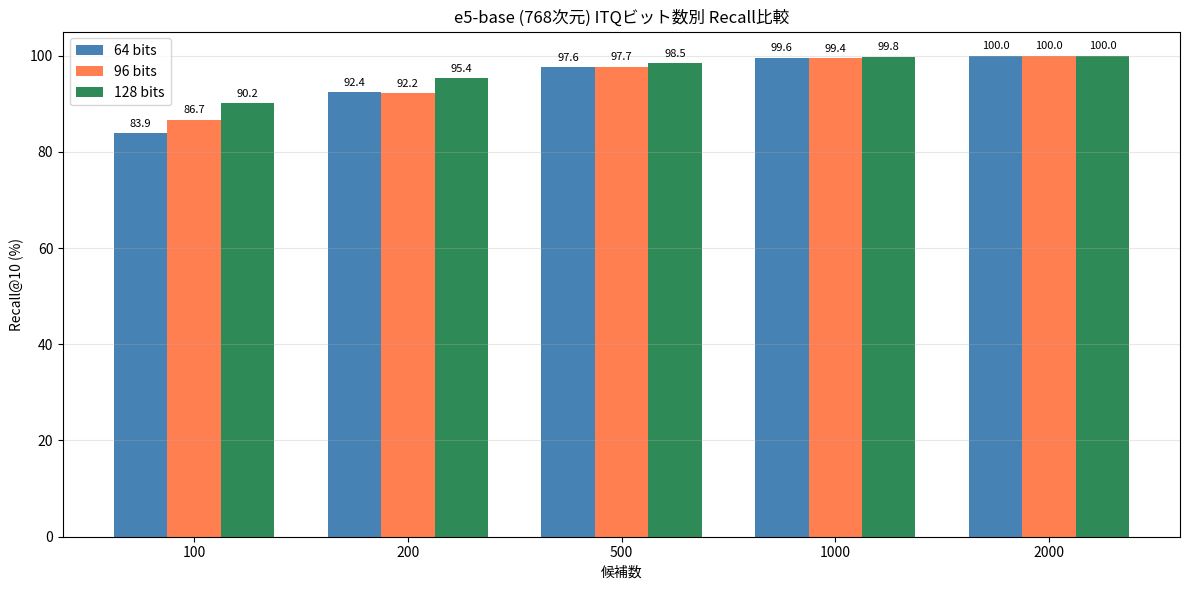

In [9]:
# 棒グラフ: ビット数別×候補数別 Recall
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(CANDIDATE_SIZES))
width = 0.25
colors = ['steelblue', 'coral', 'seagreen']

for i, n_bits in enumerate(N_BITS_LIST):
    vals = [itq_results[n_bits]['recalls'][k]*100 for k in CANDIDATE_SIZES]
    bars = ax.bar(x + i * width, vals, width, 
                  label=f'{n_bits} bits', 
                  color=colors[i])
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

ax.set_xlabel('候補数')
ax.set_ylabel(f'Recall@{TOP_K} (%)')
ax.set_title(f'e5-base ({MODEL_DIM}次元) ITQビット数別 Recall比較')
ax.set_xticks(x + width)
ax.set_xticklabels([str(k) for k in CANDIDATE_SIZES])
ax.legend()
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/44_e5_base_bits_recall_comparison.png', dpi=150)
plt.show()

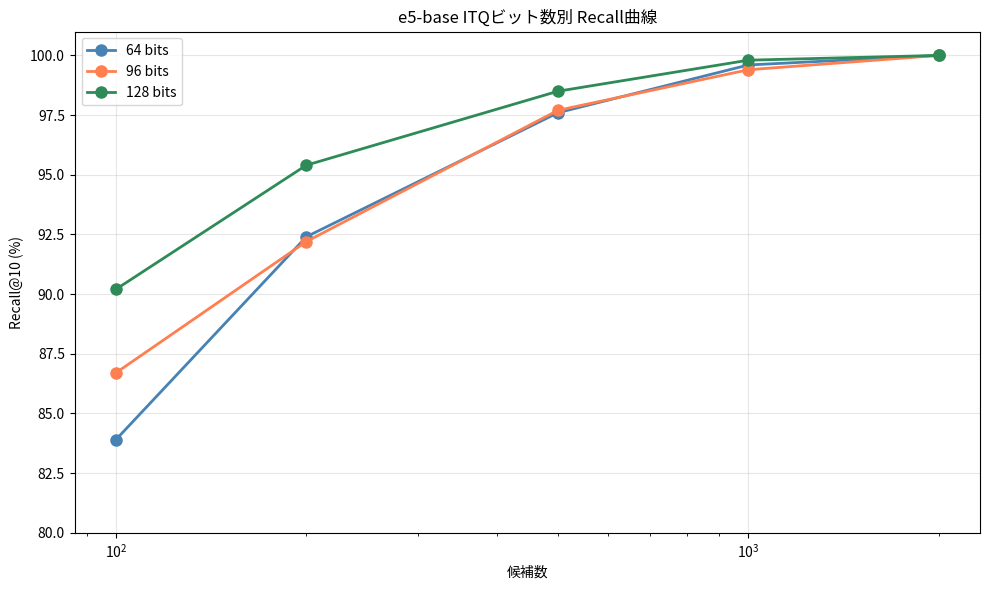

In [10]:
# 折れ線グラフ: 候補数 vs Recall (ビット数別)
fig, ax = plt.subplots(figsize=(10, 6))

for i, n_bits in enumerate(N_BITS_LIST):
    vals = [itq_results[n_bits]['recalls'][k]*100 for k in CANDIDATE_SIZES]
    ax.plot(CANDIDATE_SIZES, vals, 'o-', label=f'{n_bits} bits', 
            color=colors[i], linewidth=2, markersize=8)

ax.set_xlabel('候補数')
ax.set_ylabel(f'Recall@{TOP_K} (%)')
ax.set_title(f'e5-base ITQビット数別 Recall曲線')
ax.legend()
ax.set_ylim(80, 101)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('../data/44_e5_base_bits_recall_curve.png', dpi=150)
plt.show()

## 6. トレードオフ分析

In [11]:
# ハッシュサイズ vs Recall トレードオフ
print('=' * 60)
print('トレードオフ分析')
print('=' * 60)

# 候補1000件でのRecallを基準に分析
ref_k = 1000

tradeoff_data = []
for n_bits, data in itq_results.items():
    recall = data['recalls'][ref_k]
    hash_bytes = data['hash_bytes_per_doc']
    total_hash_size_mb = N_SAMPLES * hash_bytes / 1024 / 1024
    
    # 40万件での推定サイズ
    est_size_400k_mb = 400000 * hash_bytes / 1024 / 1024
    
    tradeoff_data.append({
        'ビット数': n_bits,
        f'Recall@10 (候補{ref_k})': f'{recall*100:.1f}%',
        'ハッシュ/doc (bytes)': hash_bytes,
        f'{N_SAMPLES}件 (MB)': f'{total_hash_size_mb:.2f}',
        '40万件推定 (MB)': f'{est_size_400k_mb:.1f}',
    })

df_tradeoff = pd.DataFrame(tradeoff_data)
display(df_tradeoff)

トレードオフ分析


,ビット数,Recall@10 (候補1000),ハッシュ/doc (bytes),5000件 (MB),40万件推定 (MB)
0,64,99.6%,8,0.04,3.1
1,96,99.4%,12,0.06,4.6
2,128,99.8%,16,0.08,6.1


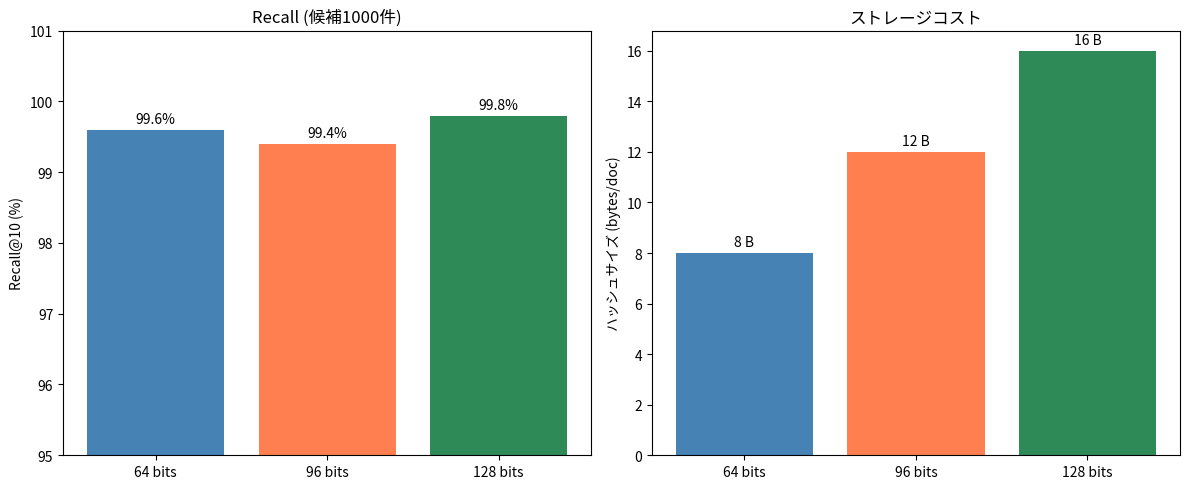

In [12]:
# 効率指標グラフ
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 左: ビット数 vs Recall
recalls_at_ref = [itq_results[n]['recalls'][ref_k]*100 for n in N_BITS_LIST]
axes[0].bar(range(len(N_BITS_LIST)), recalls_at_ref, color=colors)
axes[0].set_xticks(range(len(N_BITS_LIST)))
axes[0].set_xticklabels([f'{n} bits' for n in N_BITS_LIST])
axes[0].set_ylabel(f'Recall@{TOP_K} (%)')
axes[0].set_title(f'Recall (候補{ref_k}件)')
axes[0].set_ylim(95, 101)

for i, r in enumerate(recalls_at_ref):
    axes[0].annotate(f'{r:.1f}%', xy=(i, r), xytext=(0, 5),
                     textcoords='offset points', ha='center')

# 右: ビット数 vs ハッシュサイズ
hash_sizes = [itq_results[n]['hash_bytes_per_doc'] for n in N_BITS_LIST]
axes[1].bar(range(len(N_BITS_LIST)), hash_sizes, color=colors)
axes[1].set_xticks(range(len(N_BITS_LIST)))
axes[1].set_xticklabels([f'{n} bits' for n in N_BITS_LIST])
axes[1].set_ylabel('ハッシュサイズ (bytes/doc)')
axes[1].set_title('ストレージコスト')

for i, s in enumerate(hash_sizes):
    axes[1].annotate(f'{s} B', xy=(i, s), xytext=(0, 5),
                     textcoords='offset points', ha='center')

plt.tight_layout()
plt.savefig('../data/44_e5_base_bits_tradeoff.png', dpi=150)
plt.show()

## 7. 評価結果まとめ

In [13]:
print('=' * 70)
print('e5-base ITQビット数検証 結論')
print('=' * 70)

print(f'''
■ 実験条件
  モデル: {MODEL_NAME} ({MODEL_DIM}次元)
  サンプル数: {N_SAMPLES}件
  評価クエリ数: {N_QUERIES}件
  ビット数: {N_BITS_LIST}
''')

print('\n■ Recall@10 結果 (候補1000件)')
for n_bits in N_BITS_LIST:
    recall = itq_results[n_bits]['recalls'][1000]
    print(f'  {n_bits} bits: {recall*100:.1f}%')

# 最適なビット数の判定
recalls_1000 = {n: itq_results[n]['recalls'][1000] for n in N_BITS_LIST}
best_bits = max(recalls_1000, key=recalls_1000.get)
min_bits_for_99 = min([n for n in N_BITS_LIST if recalls_1000[n] >= 0.99], default=N_BITS_LIST[-1])

print(f'''
■ 分析結果
  - 最高Recall: {best_bits} bits ({recalls_1000[best_bits]*100:.1f}%)
  - 99%以上の最小ビット数: {min_bits_for_99} bits
  - 64 bits vs 128 bits の差: {(recalls_1000[128] - recalls_1000[64])*100:.1f}pt

■ ストレージコスト (40万件)
  - 64 bits: {400000 * 8 / 1024 / 1024:.1f} MB
  - 96 bits: {400000 * 12 / 1024 / 1024:.1f} MB
  - 128 bits: {400000 * 16 / 1024 / 1024:.1f} MB

■ 推奨設定
  - 精度重視: 128 bits
  - バランス: 96 bits (e5-baseのデフォルト)
  - ストレージ重視: 64 bits (ただしRecall低下に注意)
''')

e5-base ITQビット数検証 結論

■ 実験条件
  モデル: intfloat/multilingual-e5-base (768次元)
  サンプル数: 5000件
  評価クエリ数: 100件
  ビット数: [64, 96, 128]


■ Recall@10 結果 (候補1000件)
  64 bits: 99.6%
  96 bits: 99.4%
  128 bits: 99.8%

■ 分析結果
  - 最高Recall: 128 bits (99.8%)
  - 99%以上の最小ビット数: 64 bits
  - 64 bits vs 128 bits の差: 0.2pt

■ ストレージコスト (40万件)
  - 64 bits: 3.1 MB
  - 96 bits: 4.6 MB
  - 128 bits: 6.1 MB

■ 推奨設定
  - 精度重視: 128 bits
  - バランス: 96 bits (e5-baseのデフォルト)
  - ストレージ重視: 64 bits (ただしRecall低下に注意)



## 評価結果まとめ

### 実験条件
| 項目 | 値 |
|------|-----|
| モデル | intfloat/multilingual-e5-base (768次元) |
| サンプル数 | 5000件 |
| 評価クエリ数 | 100件 |
| ビット数 | 64, 96, 128 |

### 主要な結果

| ビット数 | Recall@10 (候補1000) | ハッシュサイズ | 40万件推定 |
|---------|---------------------|---------------|-----------|
| 64 bits | 99.6% | 8 bytes/doc | 3.1 MB |
| 96 bits | 99.4% | 12 bytes/doc | 4.6 MB |
| 128 bits | 99.8% | 16 bytes/doc | 6.1 MB |

### 評価・考察

**✓ 良い点:**
1. **64 bits で十分な精度**: 候補1000件で99.6%のRecall達成。768次元に対して約8%のビット数で高精度
2. **ビット数間の差が小さい**: 64→128 bits でわずか0.2ptの改善。コスト対効果が低い
3. **ストレージ効率**: 64 bits なら40万件でも3.1MBと非常にコンパクト

**△ 注意点:**
1. **候補100件では差が顕著**: 64 bits (83.9%) vs 128 bits (90.2%) で6.3ptの差
2. **96 bits が64 bitsより低い場面あり**: ランダム性の影響と考えられる

### 結論

**推奨設定: 64 bits**
- e5-base (768次元) に対して 64 bits で十分な精度（Recall 99.6%）を達成
- 96/128 bits へ増やしても改善幅は限定的（0.2pt以下）
- ストレージコストは半分（64 bits: 3.1MB vs 128 bits: 6.1MB）
- 候補数を1000件以上確保すれば、ビット数削減のデメリットは最小化される